# A Study of Potential Influencing Factors on Canadian Immigrants.
### CSCI 6405 -- Data Mining Project, Dalhousie University.
### By Hongwei Zhang, January - April 2023.

In [141]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sb
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize, KBinsDiscretizer
from sklearn.impute import KNNImputer
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from mlxtend.frequent_patterns import apriori, association_rules

## Experiment 1: Study the reasons why Canadian immigrants leave their home countries.
### Datasets used: The number of immigrants in Canada by country for the last decade (2011-2021), and economic and social indicators for the corresponding country.

In [142]:
# Organizing and processing Canadian immigration dataset.
im = pd.read_csv("Datasets/immigrants.csv", skiprows=14, nrows=215)
im.columns=['Birthplace', '1980-1990', '1991-2000', '2001-2010', '2011-2021']

for i in range(len(im)):
    if im['Birthplace'][i][-2:].isdigit():
        im['Birthplace'][i] = im['Birthplace'][i][0:-3]
    if im['Birthplace'][i][-1].isdigit():
        im['Birthplace'][i] = im['Birthplace'][i][0:-2]

    im['1980-1990'][i] = int(im['1980-1990'][i].replace(',', ''))
    im['1991-2000'][i] = int(im['1991-2000'][i].replace(',', ''))
    im['2001-2010'][i] = int(im['2001-2010'][i].replace(',', ''))
    im['2011-2021'][i] = int(im['2011-2021'][i].replace(',', ''))
    if im['1980-1990'][i] == 0 and im['1991-2000'][i] == 0 and im['2001-2010'][i] == 0 and im['2011-2021'][i] == 0:
        im=im.drop(labels=i)

im = im.sort_values(by=['Birthplace'])
im.reset_index(drop=True, inplace=True)

print("Number of country/region:", len(im))
im.head()

Number of country/region: 200


,Birthplace,1980-1990,1991-2000,2001-2010,2011-2021
0,Afghanistan,3920,14745,22280,21340
1,Albania,15,4130,8000,5500
2,Algeria,1345,11745,32430,32580
3,Andorra,0,0,0,30
4,Angola,415,390,1315,580


In [143]:
# Filtering data from each dataset for 2011 and 2021.
'''
Dataset name and meaning:
gdp: GDP per capita (current US$), GDP11 = GDP per capita for 2011, GDP21 = GDP per capita for 2021.
life: Life expectancy at birth, total (years), LE11, LE21.
inflation: Inflation, consumer prices (annual %), IF11, IF21.
employment: Employment to population ratio, 15+, total (%), EM11, EM21.
female: Labor force participation rate, female (% of female population ages 15+), FM11, FM21.
health: Current health expenditure (% of GDP), HE11, HE21.
education: Government expenditure on education, total (% of GDP), ED11, ED21.
'''

gdp = pd.read_csv("Datasets/gdp.csv", skiprows=4, nrows=266, usecols=[0, 55, 65])
gdp.columns = ['Birthplace', 'GDP11', 'GDP21']
life = pd.read_csv("Datasets/life.csv", skiprows=4, usecols=[55, 65])
life.columns = ['LE11', 'LE21']
inflation = pd.read_csv("Datasets/inflation.csv", skiprows=4, usecols=[55, 65])
inflation.columns = ['IF11', 'IF21']
employment = pd.read_csv("Datasets/employment.csv", skiprows=4, usecols=[55, 65])
employment.columns = ['EM11', 'EM21']
female = pd.read_csv("Datasets/female.csv", skiprows=4, usecols=[55, 65])
female.columns = ['FM11', 'FM21']
health = pd.read_csv("Datasets/health.csv", skiprows=4, usecols=[55, 65])
health.columns = ['HE11', 'HE21']
education = pd.read_csv("Datasets/education.csv", skiprows=4, usecols=[55, 65])
education.columns = ['ED11', 'ED21']

comb = pd.concat([gdp, life, inflation, employment, female, health, education], axis=1)
print("Number of country/region:", len(comb))
comb.head()

Number of country/region: 266


,Birthplace,GDP11,GDP21,LE11,LE21,IF11,IF21,EM11,EM21,FM11,FM21,HE11,HE21,ED11,ED21
0,Aruba,26044.435933,29342.100858,75.465000,NaN,4.316297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.11913,NaN
1,Africa Eastern and Southern,1792.847428,1537.336021,59.293271,NaN,8.971206,6.079328,65.610090,64.030243,64.596561,64.434443,6.774233,NaN,4.38598,NaN
2,Afghanistan,621.912311,368.754614,61.419000,NaN,11.804186,NaN,43.180000,NaN,15.784000,NaN,8.561907,NaN,3.46201,NaN
3,Africa Western and Central,1856.687669,1757.030626,55.013138,NaN,4.018699,3.837868,61.222896,58.388407,57.979904,54.091940,3.547476,NaN,2.66890,NaN
4,Angola,4511.153227,1953.533757,57.596000,NaN,13.482468,25.754266,71.628998,68.557999,74.873001,74.463997,2.645608,NaN,3.03000,NaN


In [144]:
# Use the data imputation algorithm to fill in the missing data.

def imputation (file, data, col1, col2):  # csv file, table, index of the two columns need to be filled.
    f = pd.read_csv(file, skiprows=4, usecols=range(35, 66)).to_numpy()  # 1991-2021

    for i in range(len(data)):
        # Find the location of the missing data and read all data from the dataset for a certain time range.
        if math.isnan(data.iloc[[i], [col1]].values) or math.isnan(data.iloc[[i], [col2]].values):
            row = []
            for j in f[i]:
                if not math.isnan(j):
                    row.append(j)

            # If there are more than ten data exist, choose two data that are ten years apart.
            if len(row) >= 10:
                data.iloc[[i], [col1]] = row[len(row) - 10]
                data.iloc[[i], [col2]] = row[-1]

            # Otherwise, select the first and last one.
            elif 1 < len(row) < 10:
                data.iloc[[i], [col1]] = row[0]
                data.iloc[[i], [col2]] = row[-1]
            row.clear()


imputation("Datasets/gdp.csv", comb, 1, 2)
imputation("Datasets/life.csv", comb, 3, 4)
imputation("Datasets/inflation.csv", comb, 5, 6)
imputation("Datasets/employment.csv", comb, 7, 8)
imputation("Datasets/female.csv", comb, 9, 10)
imputation("Datasets/health.csv", comb, 11, 12)
imputation("Datasets/education.csv", comb, 13, 14)

# For countries or regions with too much missing data, they are removed because they cannot be imputed.
comb.dropna(axis=0,subset = ['GDP11', 'GDP21', 'LE11', 'LE21', 'IF11', 'IF21', 'EM11', 'EM21', 'FM11', 'FM21', 'HE11', 'HE21', 'ED11', 'ED21'], inplace=True)
comb = comb.sort_values(by=['Birthplace'])
comb.reset_index(drop=True, inplace=True)

print("Number of country/region:", len(comb))
comb.head()

Number of country/region: 215


,Birthplace,GDP11,GDP21,LE11,LE21,IF11,IF21,EM11,EM21,FM11,FM21,HE11,HE21,ED11,ED21
0,Afghanistan,621.912311,368.754614,61.419000,62.575000,2.178538,2.302373,43.180000,36.710999,15.784000,16.462999,8.569672,13.242202,3.46201,2.860859
1,Africa Eastern and Southern,1792.847428,1537.336021,59.293271,63.313856,8.971206,6.079328,65.610090,64.030243,64.596561,64.434443,6.923020,6.272034,4.38598,4.608170
2,Africa Western and Central,1856.687669,1757.030626,55.013138,57.226373,4.018699,3.837868,61.222896,58.388407,57.979904,54.091940,3.519651,3.366086,2.66890,3.173885
3,Albania,4437.142612,6492.872012,78.092000,76.989000,3.429123,2.041472,51.860001,51.367001,52.467999,51.653000,4.602225,5.232072,3.08000,3.100000
4,Algeria,5473.280550,3690.627878,74.123000,74.453000,4.524212,7.226063,37.686001,35.349998,14.861000,15.909000,5.117172,6.243371,6.03000,7.042397


In [145]:
# Calculate the growth rate of the relevant data from 2011 to 2021.
def increase_rate(num1, num2):
    return float(format((num2 - num1) / num1, '.4f'))

# Generate the dataset to be used.
a0, a1, a2, a3, a4, a5, a6, a7, a8 = [], [], [], [], [], [], [], [], []
for m in range(len(comb)):
    for n in range(len(im)):
        if comb['Birthplace'][m] == im['Birthplace'][n]:

            a0.append(im['Birthplace'][n])
            a1.append(im['2011-2021'][n])

            a2.append(increase_rate(comb['GDP11'][m], comb['GDP21'][m]))
            a3.append(increase_rate(comb['LE11'][m], comb['LE21'][m]))
            a4.append(increase_rate(comb['IF11'][m], comb['IF21'][m]))
            a5.append(increase_rate(comb['EM11'][m], comb['EM21'][m]))
            a6.append(increase_rate(comb['FM11'][m], comb['FM21'][m]))
            a7.append(increase_rate(comb['HE11'][m], comb['HE21'][m]))
            a8.append(increase_rate(comb['ED11'][m], comb['ED21'][m]))

# The resulting dataset contains the number of immigrants in Canada from 2011 to 2021 by country or region,
# and the rate of change for each other indicator over the decade.

dataset = pd.DataFrame({'Birthplace':a0, 'Immigration':a1, 'GDP_Change':a2,
                        'LE_Change':a3, 'IF_Change':a4, 'EM_Change':a5,
                        'FM_Change':a6, 'HE_Change':a7, 'ED_Change':a8})
print("Number of country/region:", len(dataset))
dataset.head()

Number of country/region: 138


,Birthplace,Immigration,GDP_Change,LE_Change,IF_Change,EM_Change,FM_Change,HE_Change,ED_Change
0,Afghanistan,21340,-0.4071,0.0188,0.0568,-0.1498,0.0430,0.5452,-0.1736
1,Albania,5500,0.4633,-0.0141,-0.4047,-0.0095,-0.0155,0.1369,0.0065
2,Algeria,32580,-0.3257,0.0045,0.5972,-0.0620,0.0705,0.2201,0.1679
3,Angola,580,-0.5670,0.0810,0.9102,-0.0429,-0.0055,-0.0600,-0.2029
4,Armenia,2120,0.4343,-0.0154,-0.0608,-0.0042,0.0415,0.2274,-0.1185


In [146]:
# Normalize the number of immigrants so that the data falls between 0 and 1.
nor = normalize([dataset['Immigration']])
dataset['Immigration'] = nor[0][:]
dataset.head()

,Birthplace,Immigration,GDP_Change,LE_Change,IF_Change,EM_Change,FM_Change,HE_Change,ED_Change
0,Afghanistan,0.036369,-0.4071,0.0188,0.0568,-0.1498,0.0430,0.5452,-0.1736
1,Albania,0.009373,0.4633,-0.0141,-0.4047,-0.0095,-0.0155,0.1369,0.0065
2,Algeria,0.055525,-0.3257,0.0045,0.5972,-0.0620,0.0705,0.2201,0.1679
3,Angola,0.000988,-0.5670,0.0810,0.9102,-0.0429,-0.0055,-0.0600,-0.2029
4,Armenia,0.003613,0.4343,-0.0154,-0.0608,-0.0042,0.0415,0.2274,-0.1185


In [147]:
dataset.describe()

,Immigration,GDP_Change,LE_Change,IF_Change,EM_Change,FM_Change,HE_Change,ED_Change
count,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000
mean,0.024245,0.195110,0.025472,0.538188,-0.002873,0.018708,0.078312,0.139569
std,0.081897,0.421843,0.038722,4.040183,0.080272,0.098310,0.271089,0.414776
min,0.000017,-0.620800,-0.056900,-3.370100,-0.149800,-0.201700,-0.438200,-0.826800
25%,0.001506,-0.047000,0.002950,-0.483950,-0.052650,-0.029500,-0.058300,-0.073650
50%,0.004810,0.120600,0.018650,-0.215600,-0.013000,0.007950,0.038500,0.050400
75%,0.012637,0.393600,0.039300,0.143275,0.029250,0.051625,0.178200,0.273675
max,0.666311,1.927000,0.238600,30.128700,0.312900,0.499600,1.392100,2.404700


<Axes: >

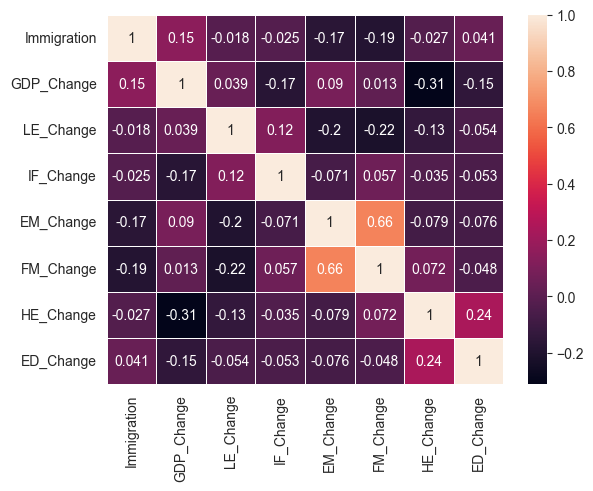

In [148]:
# Generate correlation coefficient heat map.
corr = dataset.corr(numeric_only=True)
sb.heatmap(corr, annot=True, linewidth=0.5)

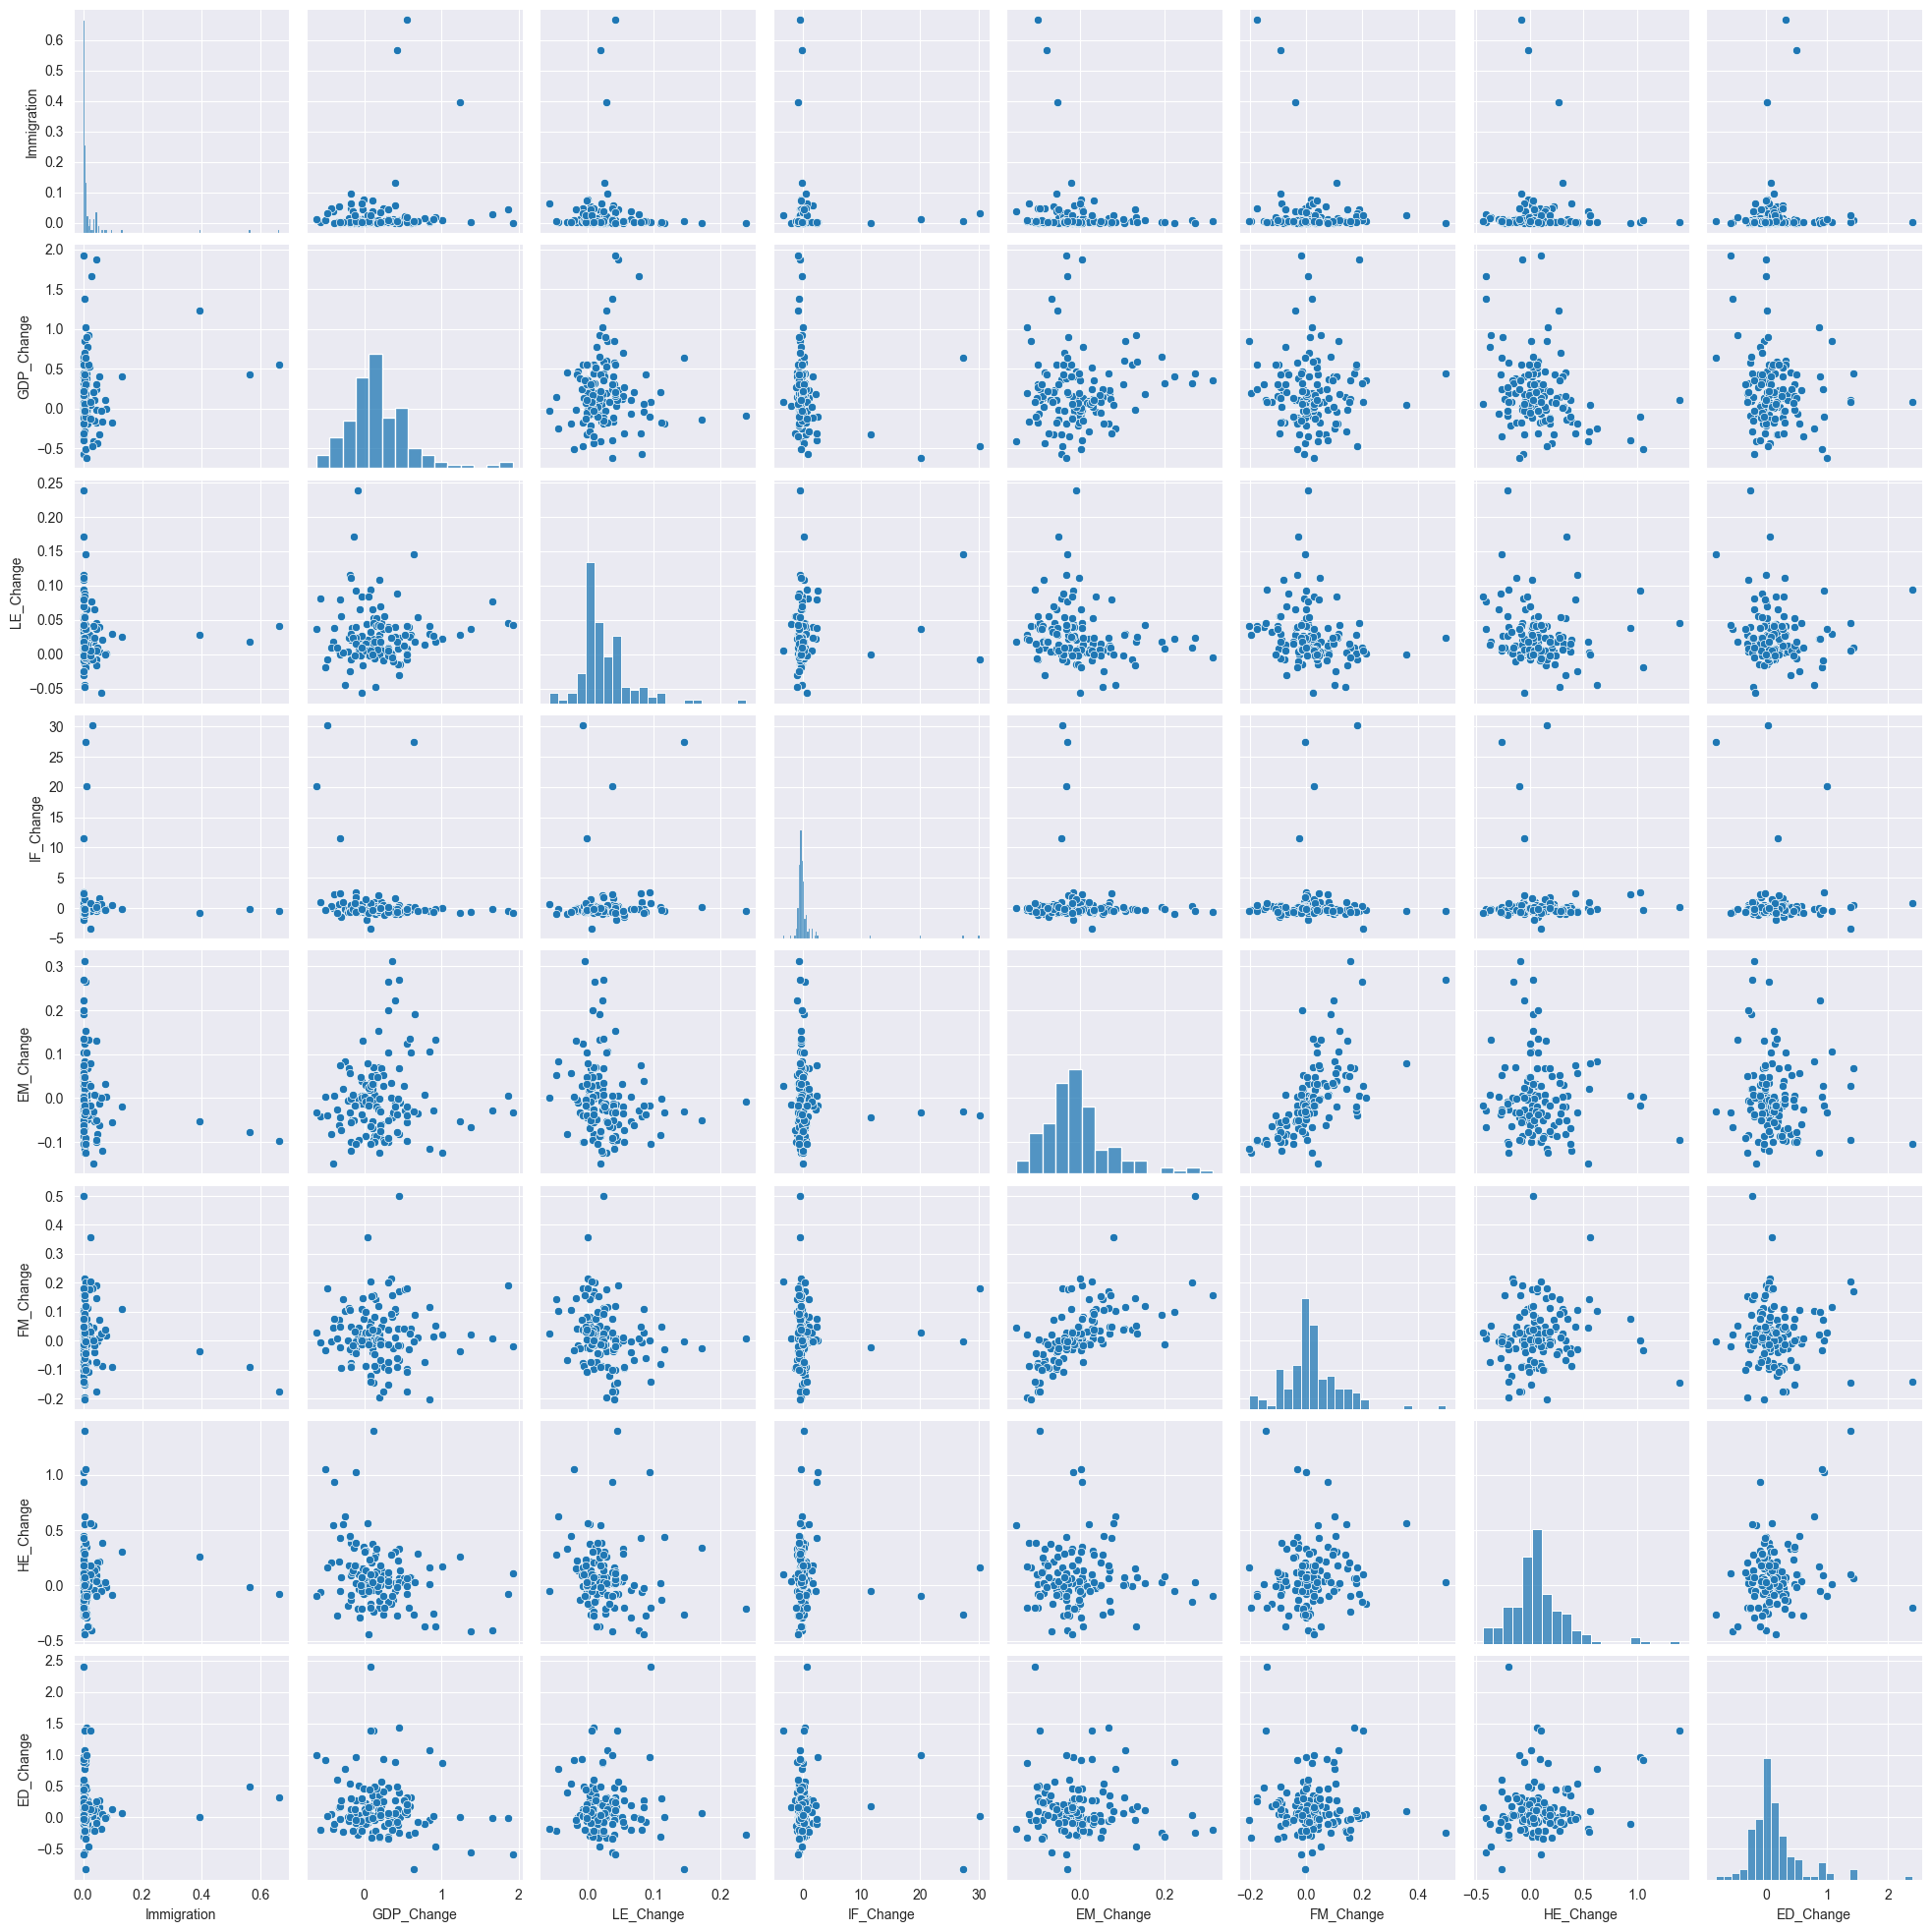

In [149]:
# Generate pairwise graphs based on the dataset.
sb.pairplot(dataset)

[Text(0.5, 0, 'Growth rate of government expenditure on education'),
 Text(0, 0.5, 'Country or Region')]

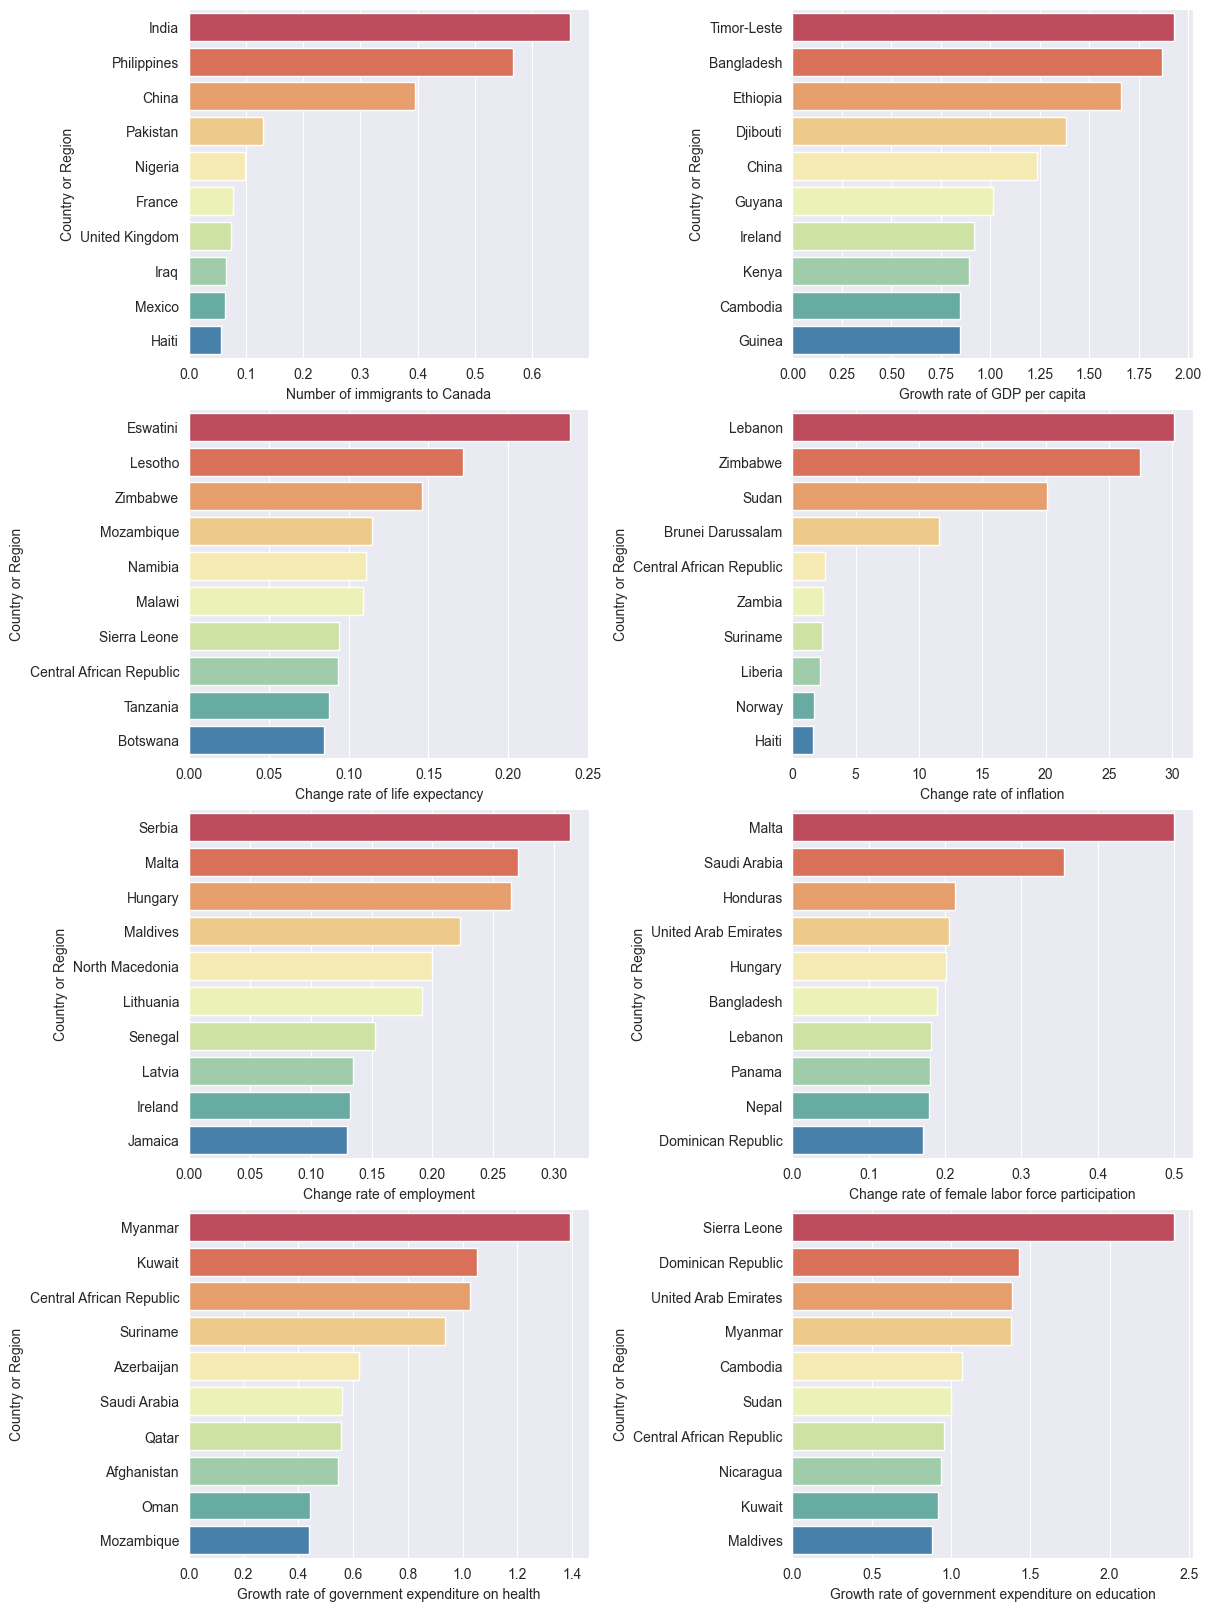

In [150]:
# Display bar graphs for relevant data.
fig, axes = plt.subplots(nrows=4, ncols=2, constrained_layout=True, figsize=(12,16))

sb.barplot(x='Immigration', y='Birthplace', data=dataset.nlargest(10, 'Immigration'), ax=axes[0,0], palette="Spectral")\
    .set(xlabel='Number of immigrants to Canada', ylabel='Country or Region')

sb.barplot(x='GDP_Change' ,y='Birthplace', data=dataset.nlargest(10, 'GDP_Change'), ax=axes[0,1], palette="Spectral")\
    .set(xlabel='Growth rate of GDP per capita', ylabel='Country or Region')

sb.barplot(x='LE_Change',y='Birthplace', data=dataset.nlargest(10, 'LE_Change'), ax=axes[1,0], palette="Spectral")\
    .set(xlabel='Change rate of life expectancy', ylabel='Country or Region')

sb.barplot(x='IF_Change' ,y='Birthplace', data=dataset.nlargest(10, 'IF_Change'), ax=axes[1,1], palette="Spectral")\
    .set(xlabel='Change rate of inflation', ylabel='Country or Region')

sb.barplot(x='EM_Change',y='Birthplace', data=dataset.nlargest(10, 'EM_Change'), ax=axes[2,0], palette="Spectral")\
    .set(xlabel='Change rate of employment', ylabel='Country or Region')

sb.barplot(x='FM_Change',y='Birthplace', data=dataset.nlargest(10, 'FM_Change'), ax=axes[2,1], palette="Spectral")\
    .set(xlabel='Change rate of female labor force participation', ylabel='Country or Region')

sb.barplot(x='HE_Change' ,y='Birthplace', data=dataset.nlargest(10, 'HE_Change'), ax=axes[3,0], palette="Spectral")\
    .set(xlabel='Growth rate of government expenditure on health', ylabel='Country or Region')

sb.barplot(x='ED_Change',y='Birthplace', data=dataset.nlargest(10, 'ED_Change'), ax=axes[3,1], palette="Spectral")\
    .set(xlabel='Growth rate of government expenditure on education', ylabel='Country or Region')

2 clusters, the silhouette score is 0.5557721755394519
3 clusters, the silhouette score is 0.5397195822579753
4 clusters, the silhouette score is 0.5112592416955813
5 clusters, the silhouette score is 0.517358431865671
6 clusters, the silhouette score is 0.5416227355797484


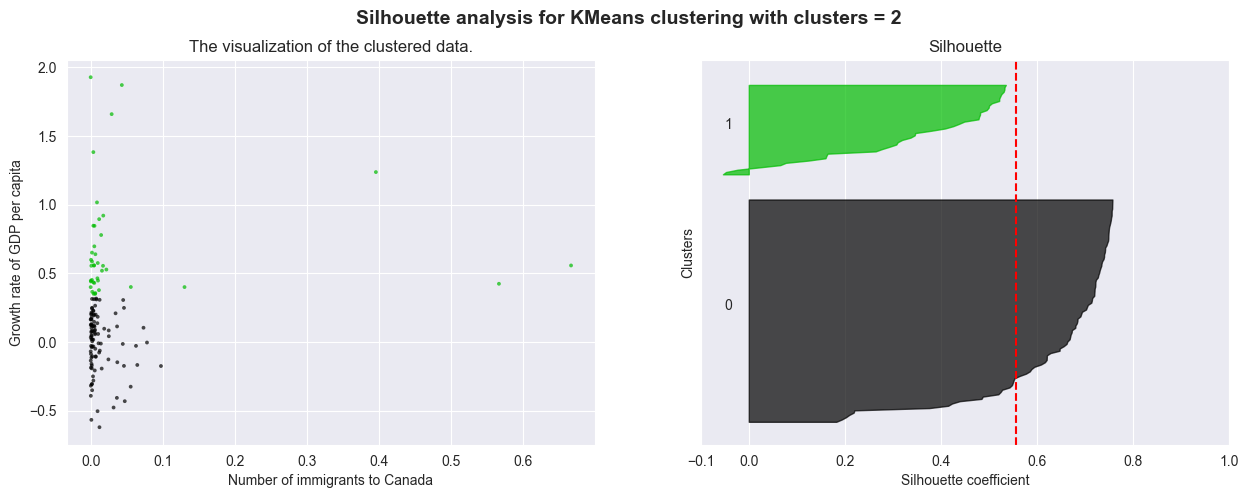

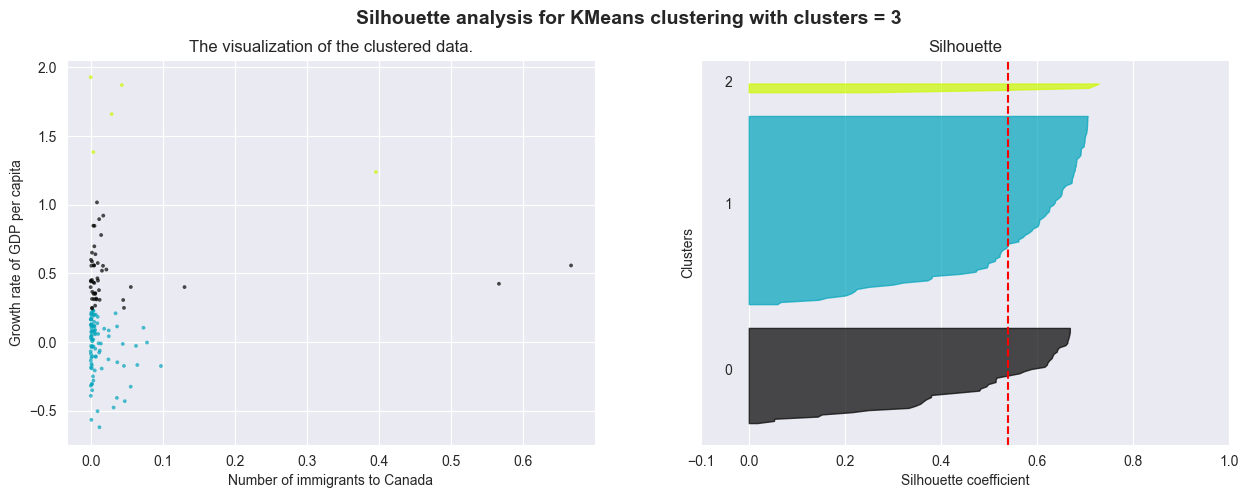

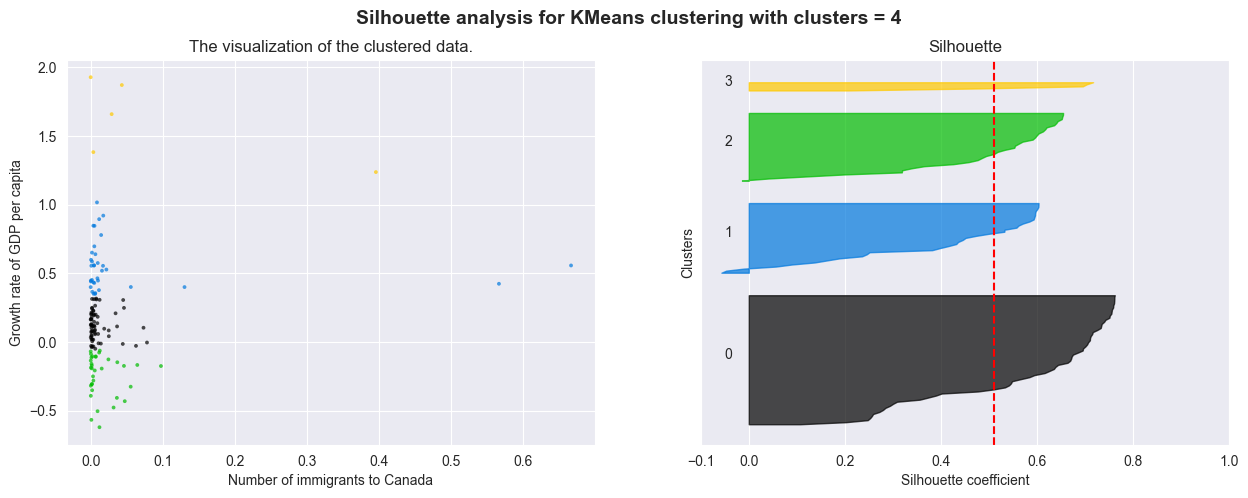

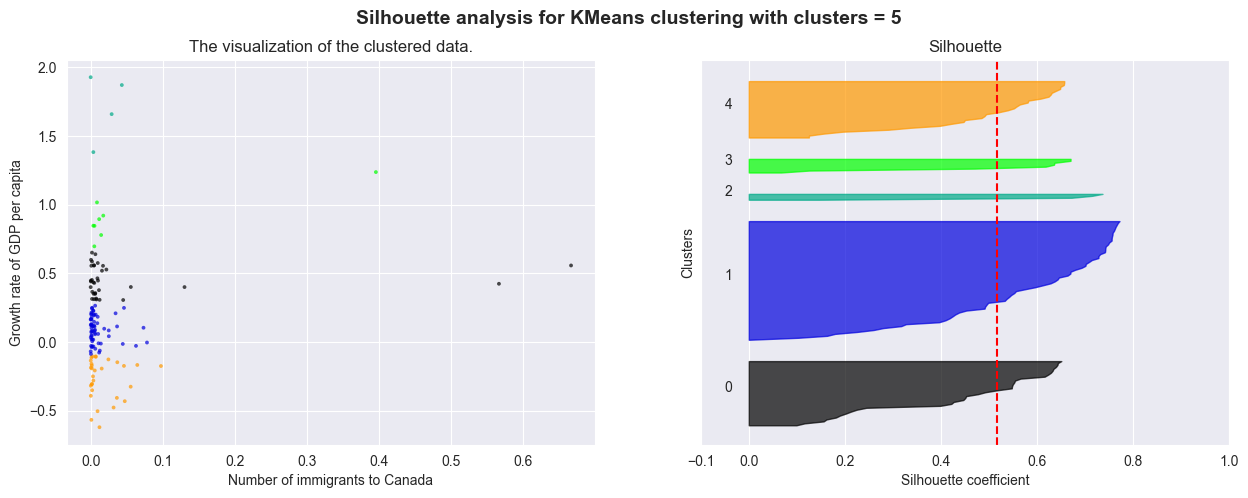

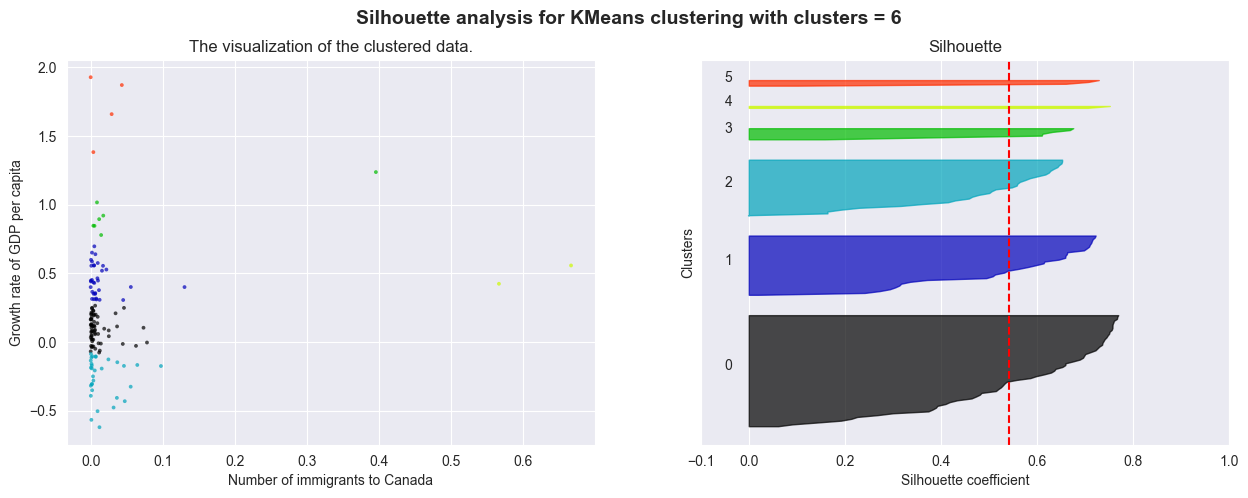

In [151]:
'''
Perform Kmeans clustering on the dataset, calculate the silhouette coefficients, and draw the silhouette plots.
The code used to draw the silhouette plots is from scikit-learn:
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

The results and silhouette plots from 2 clusters to 6 clusters are shown separately.
In order to find the most suitable number of clusters for clustering.
'''

for i in range(2, 7):
    X1 = pd.DataFrame({'Immigration':nor[0][:], 'GDP_Change':a2}).to_numpy()
    c1 = KMeans(n_clusters=i, random_state=0, n_init=10)
    label1 = c1.fit_predict(X1)
    silhouette = silhouette_score(X1, label1)
    print(i, 'clusters, the silhouette score is', silhouette)

    sample_silhouette = silhouette_samples(X1, label1)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    ax2.set_xlim([-0.1, 1])
    ax2.set_ylim([0, len(X1) + (i + 1) * 10])
    y_lower = 10

    for n in range(i):
        cluster_silhouette_values = sample_silhouette[label1 == n]
        cluster_silhouette_values.sort()
        cluster_size = cluster_silhouette_values.shape[0]
        y_upper = y_lower + cluster_size
        color = cm.nipy_spectral(n / i)
        ax2.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax2.text(-0.05, y_lower + 0.5 * cluster_size, str(n))
        y_lower = y_upper + 10

    ax2.set_title("Silhouette")
    ax2.set_xlabel("Silhouette coefficient")
    ax2.set_ylabel("Clusters")
    ax2.axvline(x=silhouette, color="red", linestyle="--")
    ax2.set_yticks([])
    ax2.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(label1.astype(float) / i)
    ax1.scatter(X1[:, 0], X1[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")
    ax1.set_title("The visualization of the clustered data.")
    ax1.set_xlabel("Number of immigrants to Canada")
    ax1.set_ylabel("Growth rate of GDP per capita")
    plt.suptitle("Silhouette analysis for KMeans clustering with clusters = %d" % i, fontsize=14, fontweight="bold",)

plt.show()

In [152]:
# By comparing the silhouette coefficients to find the most suitable number of clusters.
def choose_cluster(table):
    score = 0
    n = 0

    for i in range(2, 10):
        c = KMeans(n_clusters=i, random_state=0, n_init=10)
        label = c.fit_predict(table)
        sil = silhouette_score(table, label)

        if sil > score:
            score = sil
            n = i

    print(n, 'clusters, the silhouette score is', score)
    return n

# Perform Kmeans clustering and output the clustering results for each cluster (by country).
def plot_cluster(table, n, x_label):
    color = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    cx = KMeans(n_clusters=n, random_state=0, n_init=10).fit_predict(table)
    plt.figure(figsize=(4,3))

    for j in range(n):
        plt.scatter(table[cx==j, 0], table[cx==j, 1], s=10, c=color[j], label ='Cluster %d'% (j + 1))
        group = []

        for k in range(len(a0)):
            if cx[k] == j:
                group.append(a0[k])

        print('Cluster %d:'% (j + 1), group)
        group.clear()

    plt.xlabel(x_label)
    plt.ylabel('Immigrants')
    plt.legend()
    plt.show()

2 clusters, the silhouette score is 0.5557721755394519
Cluster 1: ['Afghanistan', 'Algeria', 'Angola', 'Austria', 'Azerbaijan', 'Bahrain', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Ecuador', 'Eswatini', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Greece', 'Guinea-Bissau', 'Hungary', 'Indonesia', 'Iraq', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kuwait', 'Lebanon', 'Lesotho', 'Liberia', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Mali', 'Mauritania', 'Mauritius', 'Mexico', 'Mongolia', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia', 'Netherlands', 'Nicaragua', 'Niger', 'Nigeria', 'North Macedonia', 'Norway', 'Oman', 'Paraguay', 'Peru', 'Poland', 'Portugal', 'Qatar', 'Russian Federation', 'Rwanda', 'Saudi Arabia', 'Senegal', 'Sierra Leon

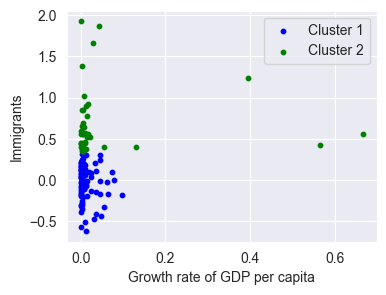

In [153]:
# Clustering using the change in GDP per capita from 2011 to 2021 with the number of immigrants to Canada in this decade.
X1 = pd.DataFrame({'Immigration':nor[0][:], 'GDP_Change':a2}).to_numpy()
plot_cluster(X1, choose_cluster(X1), 'Growth rate of GDP per capita')

2 clusters, the silhouette score is 0.9032855023615999
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta'

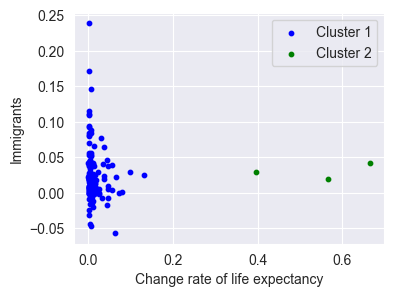

In [154]:
# Clustering using the change in life expectancy from 2011 to 2021 with the number of immigrants to Canada in this decade.
X2 = pd.DataFrame({'Immigration':nor[0][:], 'LE_Change':a3}).to_numpy()
plot_cluster(X2, choose_cluster(X2), 'Change rate of life expectancy')

2 clusters, the silhouette score is 0.9568394163186105
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 

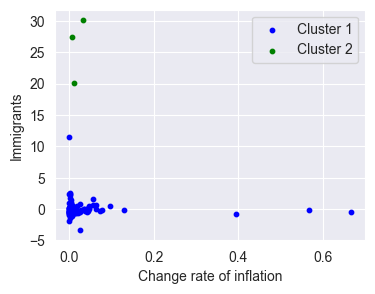

In [155]:
X3 = pd.DataFrame({'Immigration':nor[0][:], 'IF_Change':a4}).to_numpy()
plot_cluster(X3, choose_cluster(X3), 'Change rate of inflation')

2 clusters, the silhouette score is 0.8282870624680213
Cluster 1: ['China', 'India', 'Philippines']
Cluster 2: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Mal

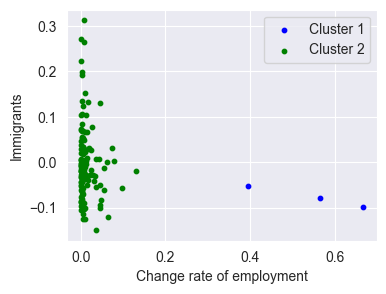

In [156]:
X4 = pd.DataFrame({'Immigration':nor[0][:], 'EM_Change':a5}).to_numpy()
plot_cluster(X4, choose_cluster(X4), 'Change rate of employment')

2 clusters, the silhouette score is 0.802600976015749
Cluster 1: ['China', 'India', 'Philippines']
Cluster 2: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Mala

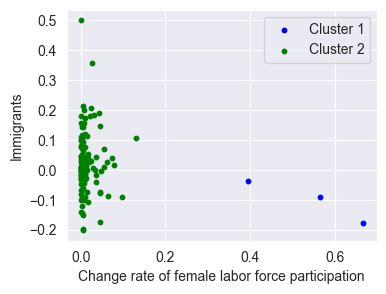

In [157]:
X5 = pd.DataFrame({'Immigration':nor[0][:], 'FM_Change':a6}).to_numpy()
plot_cluster(X5, choose_cluster(X5), 'Change rate of female labor force participation')

2 clusters, the silhouette score is 0.5795005433138019
Cluster 1: ['Albania', 'Algeria', 'Angola', 'Armenia', 'Austria', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Chad', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Latvia', 'Lebanon', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Mexico', 'Moldova', 'Mongolia', 'Morocco', 'Namibia', 'Nepal', 'Netherlands', 'Nicaragua', 'Niger', 'Nigeria', 'North Mace

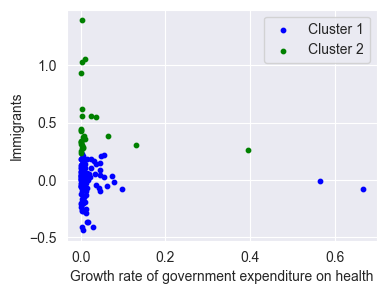

In [158]:
X6 = pd.DataFrame({'Immigration':nor[0][:], 'HE_Change':a7}).to_numpy()
plot_cluster(X6, choose_cluster(X6), 'Growth rate of government expenditure on health')

2 clusters, the silhouette score is 0.6972882611654108
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Austria', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burundi', 'Cabo Verde', 'Cameroon', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Mali', 'Malta', 'Mauritania', 'Mauritius', 'Mexico', 'Moldova', 'Mongolia', 'Morocco', 'Mozambique', 'Namibia', 'Nepal',

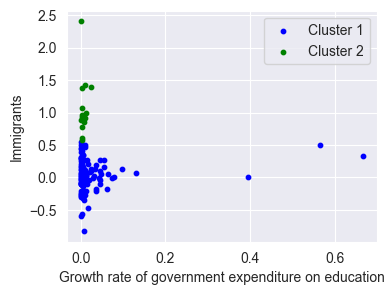

In [159]:
X7 = pd.DataFrame({'Immigration':nor[0][:], 'ED_Change':a8}).to_numpy()
plot_cluster(X7, choose_cluster(X7), 'Growth rate of government expenditure on education')

2 clusters, the silhouette score is 0.940274312591632
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', '

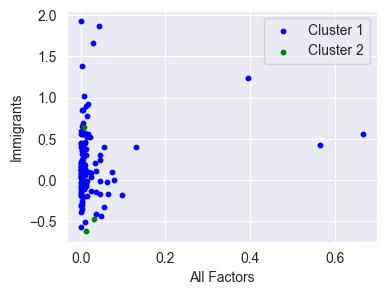

In [160]:
# Clustering with all other indicators using immigrants data.
X8 = dataset.drop(['Birthplace'], axis=1).to_numpy()
plot_cluster(X8, choose_cluster(X8), 'All Factors')

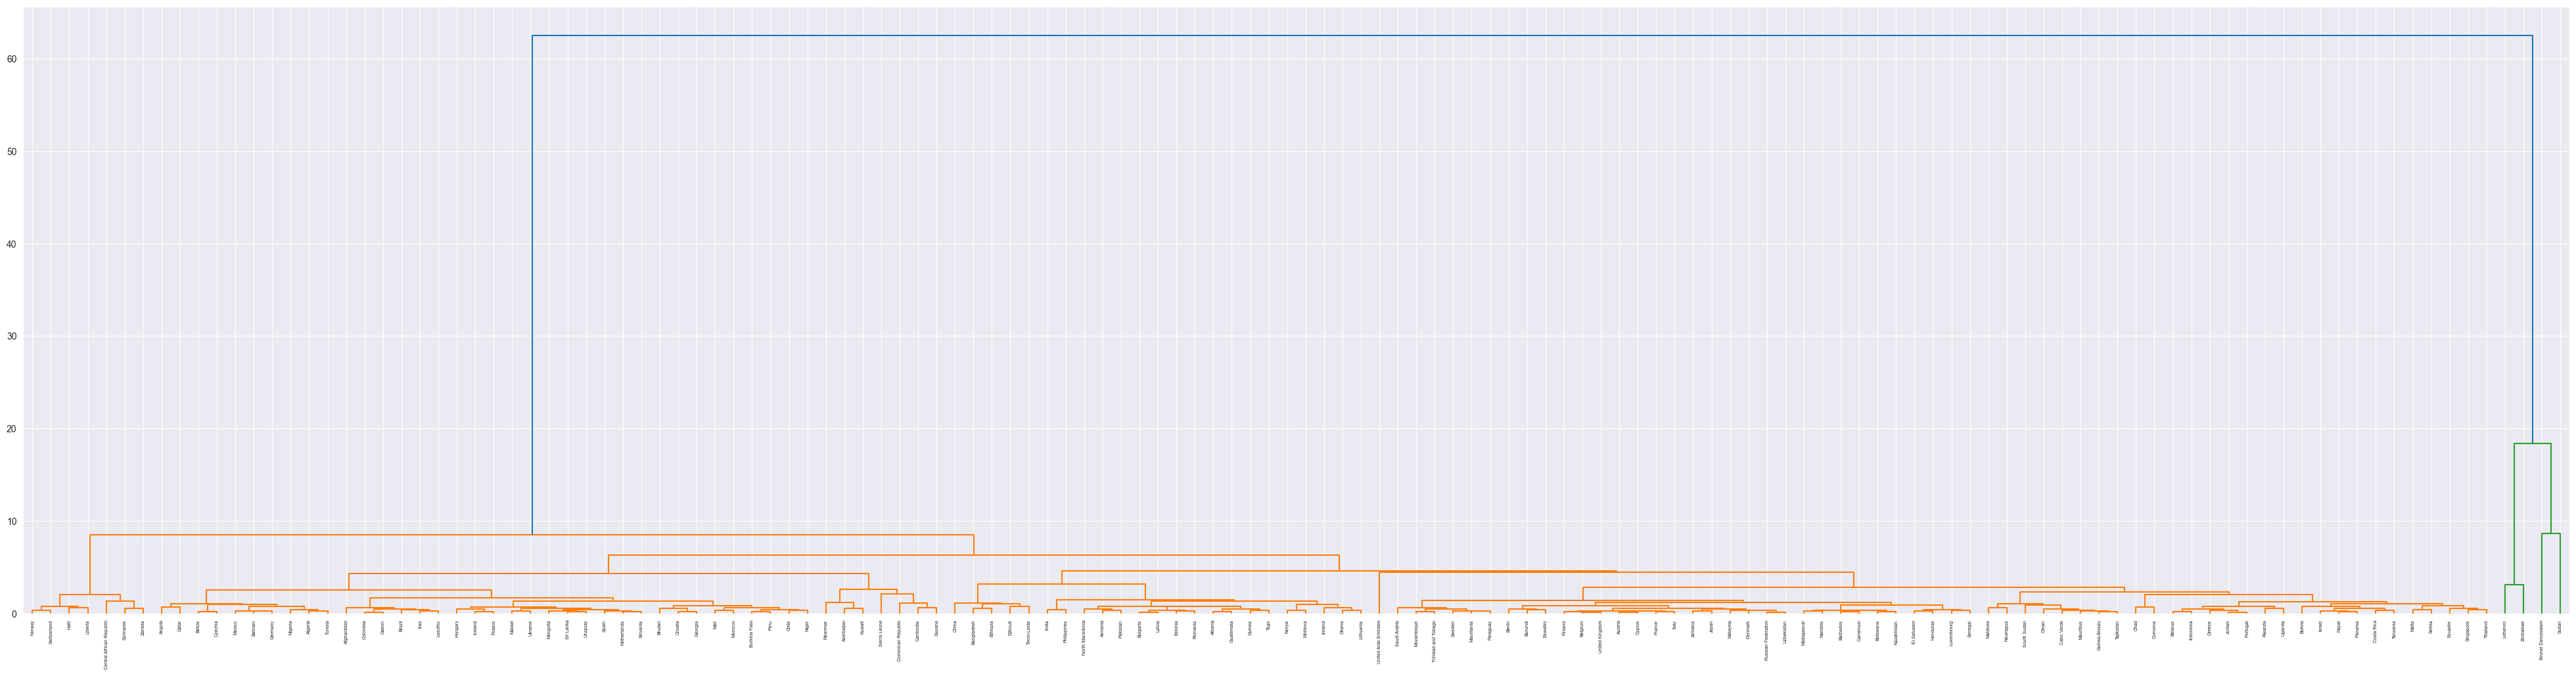

In [161]:
# Hierarchical clustering using the entire dataset.
comb_data = dataset.drop(['Birthplace'], axis=1)
plt.figure(figsize=(50, 12))
dend=sch.dendrogram(sch.linkage(comb_data,method='ward'), labels=a0)

## Experiment 2: Study the reasons why Canada attracts immigrants.
### Datasets used: Statistics on net migration to Canada over the years, as and other economic and social indicators of Canada.

In [162]:
# Generate a dataset of the number of immigrants and related indicators for Canada from 1960-2021.
year = np.arange(1960, 2022)

nm = pd.read_csv("Datasets/netmigration.csv", skiprows=39, nrows=1, usecols=range(4, 66)).to_numpy().flatten()
cgdp = pd.read_csv("Datasets/gdp.csv", skiprows=39, nrows=1, usecols=range(4, 66)).to_numpy().flatten()
cle = pd.read_csv("Datasets/life.csv", skiprows=39, nrows=1, usecols=range(4, 66)).to_numpy().flatten()
cif = pd.read_csv("Datasets/inflation.csv", skiprows=39, nrows=1, usecols=range(4, 66)).to_numpy().flatten()
cem = pd.read_csv("Datasets/employment.csv", skiprows=39, nrows=1, usecols=range(4, 66)).to_numpy().flatten()
cfm = pd.read_csv("Datasets/female.csv", skiprows=39, nrows=1, usecols=range(4, 66)).to_numpy().flatten()
che = pd.read_csv("Datasets/health.csv", skiprows=39, nrows=1, usecols=range(4, 66)).to_numpy().flatten()
cedu = pd.read_csv("Datasets/education.csv", skiprows=39, nrows=1, usecols=range(4, 66)).to_numpy().flatten()

dataset2 = pd.DataFrame({'Year': year, 'Immigrants':nm, 'GDP':cgdp, 'LE':cle, 'IF':cif, 'EM':cem, 'FM':cfm, 'HE': che, 'EDU':cedu})
dataset2.head()

,Year,Immigrants,GDP,LE,IF,EM,FM,HE,EDU
0,1960,44527,2259.250511,71.133171,1.358696,NaN,NaN,NaN,NaN
1,1961,24186,2240.433039,71.346098,1.018767,NaN,NaN,NaN,NaN
2,1962,26210,2268.585346,71.367073,1.061571,NaN,NaN,NaN,NaN
3,1963,40913,2374.498448,71.380732,1.628151,NaN,NaN,NaN,NaN
4,1964,58965,2555.111146,71.776341,1.912145,NaN,NaN,NaN,NaN


In [163]:
# Imputation of missing data.
dataset2 = KNNImputer(weights='distance').fit_transform(dataset2.drop(['Year'], axis=1))

In [164]:
dataset2 = pd.DataFrame(dataset2, columns=['Immigrants', 'GDP', 'LE', 'IF', 'EM', 'FM', 'HE', 'EDU'])
dataset2.head()

,Immigrants,GDP,LE,IF,EM,FM,HE,EDU
0,44527.0,2259.250511,71.133171,1.358696,58.821529,57.970115,9.176867,6.727497
1,24186.0,2240.433039,71.346098,1.018767,58.820562,57.969128,9.178433,6.730985
2,26210.0,2268.585346,71.367073,1.061571,58.820648,57.969213,9.178306,6.736591
3,40913.0,2374.498448,71.380732,1.628151,58.821346,57.969922,9.177214,6.762930
4,58965.0,2555.111146,71.776341,1.912145,58.822426,57.971073,9.175401,6.848604


In [165]:
dataset2.describe()

,Immigrants,GDP,LE,IF,EM,FM,HE,EDU
count,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000
mean,156270.774194,22180.192564,77.067570,3.691791,60.059463,59.404767,9.386345,5.969542
std,89463.600329,16691.514748,3.582530,2.983647,1.572546,1.805099,0.666131,0.907458
min,24186.000000,2240.433039,71.133171,0.165563,57.903999,57.462002,8.248144,4.589010
25%,94035.750000,7835.724672,73.605305,1.654824,58.821768,57.970183,9.077102,4.968248
50%,140934.000000,20367.474568,77.521951,2.447695,58.999785,58.063066,9.084091,6.194510
75%,207339.750000,39473.672523,80.306098,4.510196,61.572499,61.287499,9.419279,6.712986
max,417974.000000,52669.089963,82.048780,12.471612,63.411999,62.550999,11.022961,7.710190


<Axes: >

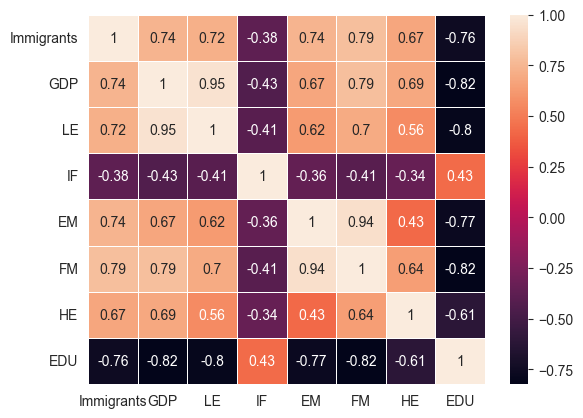

In [166]:
# Generate correlation coefficient heat map.
corr2 = dataset2.corr(numeric_only=True)
sb.heatmap(corr2, annot=True, linewidth=0.5)

In [167]:
# Binning the data, classify the data into three groups, high, medium and low, represented by 2,1,0 respectively.
dataset_bins = dataset2.copy()
est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
dataset_bins = est.fit_transform(dataset_bins)
dataset_bins = pd.DataFrame(dataset_bins, columns=['Immigrants', 'GDP', 'LE', 'IF', 'EM', 'FM', 'HE', 'EDU'])
dataset_bins.head()

,Immigrants,GDP,LE,IF,EM,FM,HE,EDU
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0


In [168]:
dataset_bins.describe()

,Immigrants,GDP,LE,IF,EM,FM,HE,EDU
count,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000
mean,0.500000,0.806452,1.096774,0.403226,0.677419,0.741935,0.548387,0.903226
std,0.646555,0.846182,0.843678,0.688540,0.864115,0.922141,0.803219,0.843678
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,2.000000,2.000000,1.000000,1.750000,2.000000,1.000000,2.000000
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


[Text(0.2857142857142857, 0.9, 'FM <= 0.5\ngini = 0.542\nsamples = 62\nvalue = [36, 21, 5]\nclass = Low'),
 Text(0.14285714285714285, 0.7, 'gini = 0.0\nsamples = 36\nvalue = [36, 0, 0]\nclass = Low'),
 Text(0.42857142857142855, 0.7, 'HE <= 1.5\ngini = 0.311\nsamples = 26\nvalue = [0, 21, 5]\nclass = Medium'),
 Text(0.2857142857142857, 0.5, 'gini = 0.0\nsamples = 14\nvalue = [0, 14, 0]\nclass = Medium'),
 Text(0.5714285714285714, 0.5, 'EM <= 1.5\ngini = 0.486\nsamples = 12\nvalue = [0, 7, 5]\nclass = Medium'),
 Text(0.42857142857142855, 0.3, 'gini = 0.32\nsamples = 5\nvalue = [0, 4, 1]\nclass = Medium'),
 Text(0.7142857142857143, 0.3, 'GDP <= 1.0\ngini = 0.49\nsamples = 7\nvalue = [0, 3, 4]\nclass = High'),
 Text(0.5714285714285714, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]\nclass = High'),
 Text(0.8571428571428571, 0.1, 'gini = 0.5\nsamples = 6\nvalue = [0, 3, 3]\nclass = Medium')]

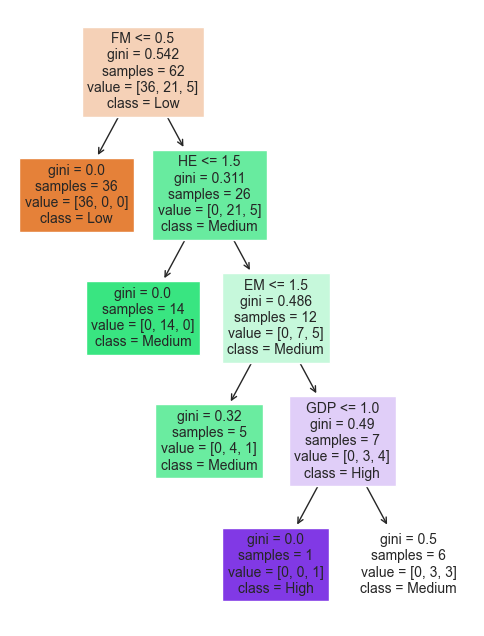

In [169]:
# Generate decision tree, find the most important influencing factors.
x_train = dataset_bins[['GDP', 'LE', 'IF', 'EM', 'FM', 'HE', 'EDU']]
y_train = dataset_bins[['Immigrants']]
dec = DecisionTreeClassifier(random_state=0).fit(x_train, y_train)
plt.figure(figsize=(6, 8))
plot_tree(dec, feature_names=['GDP', 'LE', 'IF', 'EM', 'FM', 'HE', 'EDU'], class_names=['Low', 'Medium','High'], fontsize=10, filled=True)

In [170]:
print(export_text(dec))

|--- feature_4 <= 0.50
|   |--- class: 0.0
|--- feature_4 >  0.50
|   |--- feature_5 <= 1.50
|   |   |--- class: 1.0
|   |--- feature_5 >  1.50
|   |   |--- feature_3 <= 1.50
|   |   |   |--- class: 1.0
|   |   |--- feature_3 >  1.50
|   |   |   |--- feature_0 <= 1.00
|   |   |   |   |--- class: 2.0
|   |   |   |--- feature_0 >  1.00
|   |   |   |   |--- class: 1.0



In [171]:
# Binarize the data for association rule mining.
dataset_string = dataset2.copy()

biz = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='uniform')
dataset_string = biz.fit_transform(dataset_string)

dataset_string = pd.DataFrame(dataset_string, columns=['Immigrants', 'GDP', 'LE', 'IF', 'EM', 'FM', 'HE', 'EDU'])
dataset_string = dataset_string.replace(to_replace=1, value=True)
dataset_string = dataset_string.replace(to_replace=0, value=False)
dataset_string.head()

,Immigrants,GDP,LE,IF,EM,FM,HE,EDU
0,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,True


In [172]:
# Use the Apriori algorithm for association rule mining, minimum support threshold = 5%.
ap = apriori(dataset_string, min_support=0.05, use_colnames=True)
ap

,support,itemsets
0,0.225806,(Immigrants)
1,0.306452,(GDP)
2,0.564516,(LE)
3,0.161290,(IF)
4,0.387097,(EM)
...,...,...
62,0.161290,"(FM, LE, GDP, Immigrants, HE)"
63,0.161290,"(FM, GDP, Immigrants, HE, EM)"
64,0.161290,"(FM, LE, Immigrants, HE, EM)"
65,0.177419,"(FM, LE, GDP, HE, EM)"


In [173]:
# Set minimum confidence threshold to 80%, sort by lift.
ar = association_rules(ap, metric="confidence", min_threshold=0.8)
ar.sort_values(by='lift', ascending=False, inplace=True)
ar.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
200,"(EM, LE, HE)","(Immigrants, GDP)",0.177419,0.177419,0.16129,0.909091,5.123967,0.129813,9.048387
310,"(Immigrants, GDP)","(EM, HE, FM, LE)",0.177419,0.177419,0.16129,0.909091,5.123967,0.129813,9.048387
297,"(Immigrants, FM, GDP)","(EM, LE, HE)",0.177419,0.177419,0.16129,0.909091,5.123967,0.129813,9.048387
206,"(Immigrants, GDP)","(EM, LE, HE)",0.177419,0.177419,0.16129,0.909091,5.123967,0.129813,9.048387
304,"(EM, LE, HE)","(Immigrants, FM, GDP)",0.177419,0.177419,0.16129,0.909091,5.123967,0.129813,9.048387


In [174]:
# Filter the correlation consequents to immigrants.
ar[ar['consequents']==frozenset(['Immigrants'])].reset_index(drop=True)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(HE, FM, EM)",(Immigrants),0.193548,0.225806,0.177419,0.916667,4.059524,0.133715,9.290323
1,"(HE, EM)",(Immigrants),0.193548,0.225806,0.177419,0.916667,4.059524,0.133715,9.290323
2,"(HE, LE, EM)",(Immigrants),0.177419,0.225806,0.161290,0.909091,4.025974,0.121228,8.516129
3,"(FM, LE, GDP, HE, EM)",(Immigrants),0.177419,0.225806,0.161290,0.909091,4.025974,0.121228,8.516129
4,"(HE, GDP, EM)",(Immigrants),0.177419,0.225806,0.161290,0.909091,4.025974,0.121228,8.516129
5,"(EM, HE, LE, GDP)",(Immigrants),0.177419,0.225806,0.161290,0.909091,4.025974,0.121228,8.516129
6,"(EM, HE, FM, GDP)",(Immigrants),0.177419,0.225806,0.161290,0.909091,4.025974,0.121228,8.516129
7,"(EM, HE, FM, LE)",(Immigrants),0.177419,0.225806,0.161290,0.909091,4.025974,0.121228,8.516129
8,(HE),(Immigrants),0.209677,0.225806,0.177419,0.846154,3.747253,0.130073,5.032258
9,"(FM, HE)",(Immigrants),0.209677,0.225806,0.177419,0.846154,3.747253,0.130073,5.032258


### End of Experiments.